In [1]:
from datetime import datetime
import time
import os
import copy

In [2]:
import numpy as np
import pandas as pd
import cv2
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, models, transforms
import albumentations as A
from albumentations.pytorch import ToTensorV2
# from sklearn.model_selection import train_test_split, KFold

from tqdm import tqdm
from matplotlib import pyplot as plt
# import seaborn as sns
# import plotly.express as px

from zipfile import ZipFile

In [3]:
# from torchmetrics import F1, Accuracy
# import timm

In [4]:
from FaceMaskData import FaceMaskData
from FaceMaskDataset import FaceMaskDataset

In [5]:
%load_ext tensorboard 

In [6]:
assert torch.cuda.is_available()

In [7]:
class CFG:
    seed = 42
    model_name = 'efficientnet_b4'
    pretrained = True
    # img_width = 384
    # img_height = 256
    batch_size = 32
    n_epochs = 10
    n_folds = 5
    drop_rate = 0.4
    train_size = 0.85
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

np.random.seed(CFG.seed)

# IMG_WIDTH, IMG_HEIGHT = 256, 170
# IMG_WIDTH, IMG_HEIGHT = 384, 256
# IMG_WIDTH, IMG_HEIGHT = 512, 342
# IMG_WIDTH, IMG_HEIGHT = 640, 426

In [8]:
# train_transforms = transforms.Compose([
#     transforms.CenterCrop(10),
#     transforms.ToTensor(),
#     transforms.RandomRotation(90),
# ])

# train_transforms = A.Compose([
#     A.RandomCrop(width=450, height=450),
#     A.HorizontalFlip(p=0.5),
#     A.RandomBrightnessContrast(p=0.2),
# ], bbox_params=A.BboxParams(format='coco', min_visibility=0.1, label_fields=['labels']))


train_transforms = A.Compose([
    
    A.HueSaturationValue(p=0.5),
    A.Flip(p=0.5),
    A.HorizontalFlip(p=0.5),
    A.ShiftScaleRotate(p=0.5, shift_limit=(-0.1, 0.3), scale_limit=(-0.1, 0.6), rotate_limit=(-90, 90), interpolation=0, border_mode=2),
    A.RandomBrightnessContrast(p=0.5, brightness_limit=(-0.2, 0.2), contrast_limit=(-0.2, 0.2)),
    A.OneOf([
        A.Blur(p=0.7),
        A.GaussNoise(p=0.7, var_limit=(100, 400)),
        A.MotionBlur(p=0.7),
        A.ISONoise(p=0.7),
    ], p=0.5),
    ToTensorV2(),
    
], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['labels']))

In [9]:
imgs_path = './images'
msks_path = './annotation.csv'

faceMasksData = FaceMaskData(imgs_path, msks_path)
(x_train, y_train), (x_test, y_test) = faceMasksData.load_data()

trainset = FaceMaskDataset(x_train, y_train, imgs_path, transforms=train_transforms)
validset = FaceMaskDataset(x_test, y_test, imgs_path, transforms=None)

print('Training contains {} samples which is {:g}% of the data'.format(len(trainset), len(trainset) * 100 / (len(trainset) + len(validset))))
print('Validation contains {} samples which is {:g}% of the data'.format(len(validset), len(validset) * 100 / (len(trainset) + len(validset))))

Training contains 682 samples which is 79.9531% of the data
Validation contains 171 samples which is 20.0469% of the data


In [10]:
train_loader = DataLoader(dataset=trainset, batch_size=CFG.batch_size, shuffle=True, num_workers=2)
valid_loader = DataLoader(dataset=validset, batch_size=CFG.batch_size, shuffle=False, num_workers=2)

In [11]:
dataloaders = { 'train': train_loader,
                'valid': valid_loader }

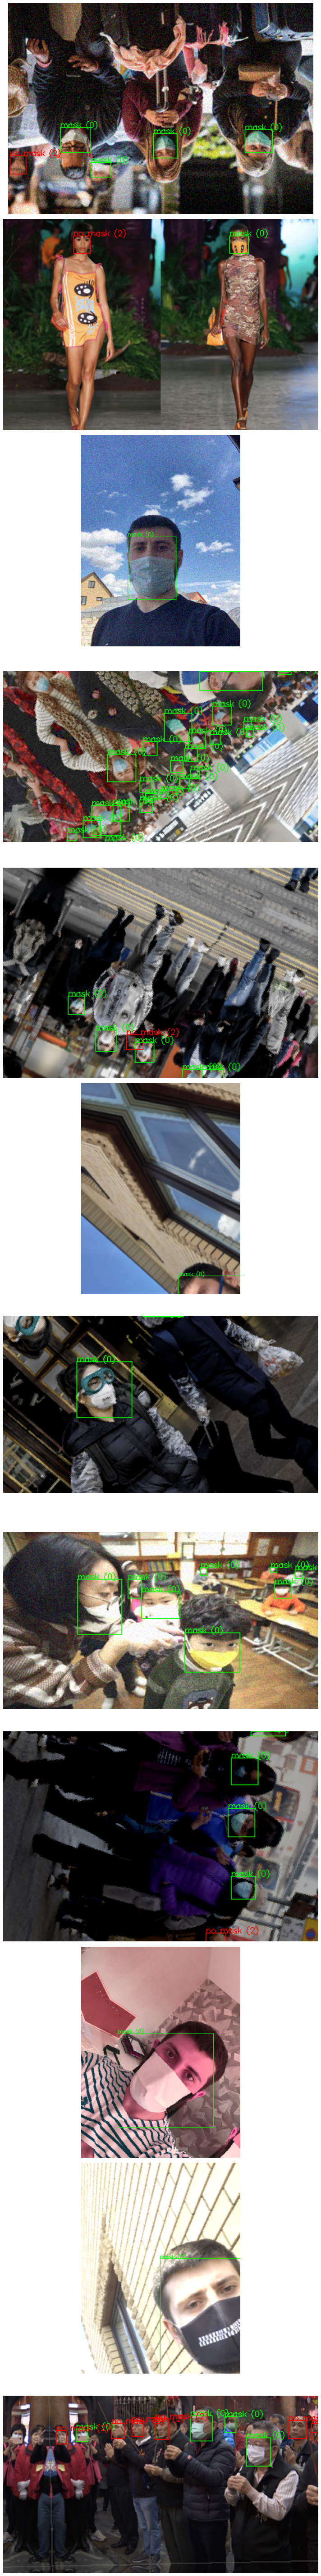

In [16]:
def norm(img):
    img = np.array(img, dtype=np.float32)
    img -= img.min()
    img /= img.max()
    return img

def show_augmented_samples(dataset, model=None):
    plt.figure(figsize=(10, 80))
    
    amount_samples = 12
    
    for i, idx in enumerate(np.random.choice(range(len(dataset)), amount_samples)):
        img, target = dataset[idx]
        plt.subplot(amount_samples, 1, i + 1)
        plt.axis('off')
        
        img = np.array(img, dtype=np.int32)
        img = np.transpose(img, (1, 2, 0))
        
        for box, cat in zip(target['bboxes'], target['labels']):
            xmin, ymin, xmax, ymax = np.array(box, dtype=np.int32)
            start_point = (xmin, ymin)
            end_point = (xmax, ymax)
            
            color = (0, 0, 0)
            if cat == 0:
                color = (0, 255, 0)
            elif cat == 1:
                color = (0, 0, 255)
            elif cat == 2:
                color = (255, 0, 0)
            thickness = 1
            img = cv2.rectangle(img, start_point, end_point, color, thickness)

            font = cv2.FONT_HERSHEY_SIMPLEX
            fontScale = 1 / 3
            img = cv2.putText(img, '{} ({})'.format(validset.decode(cat), int(cat)), start_point, font, fontScale, color, thickness, cv2.LINE_AA)
        plt.imshow(norm(img))  
    plt.tight_layout()
    plt.show()

show_augmented_samples(trainset)